###### data sources:
###### https://www.kaggle.com/drgfreeman/rockpaperscissors
###### for labels, 0 = paper, 1 = rock, 2 = scissors

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.initializers import TruncatedNormal, Constant
import matplotlib.pyplot as plt
from google.colab import drive
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score
drive.mount('/content/drive/')

# Create Data

In [ ]:
directory = r'/content/drive/My Drive/Fall_2020_Courses/MA 797/Machine Learning Project/rps_images'
image_height = 100  # original 200x300
image_width = 150
num_classes = 3

In [ ]:
#https://keras.io/api/preprocessing/image/
train_data = keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=1, # default
    image_size=(image_height, image_width),  # size of the images
    shuffle=True,
    seed=0,
    validation_split=0.40,
    subset='training',  
    interpolation="bilinear",  # default
    follow_links=False,  # default
)

Found 2188 files belonging to 3 classes.
Using 1313 files for training.


In [ ]:
val_data = keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=1, # default
    image_size=(image_height, image_width),  # default
    shuffle=True,
    seed=0,
    validation_split=0.40,
    subset='validation',  
    interpolation="bilinear",  # default
    follow_links=False,  # default
)

Found 2188 files belonging to 3 classes.
Using 875 files for validation.


In [ ]:
trainDataset = train_data.take(-1) #compiles all of the images into a Dataset
valDataset = val_data.take(-1) 

numtrain = trainDataset.cardinality().numpy()
numval = valDataset.cardinality().numpy()

images_train = np.empty((numtrain, image_height, image_width, 1))
images_valtest = np.empty((numval, image_height, image_width, 1))
labels_train = np.empty((numtrain,3))
labels_valtest = np.empty((numval,3))

In [ ]:
# convert training data to numpy arrays
count = 0
for image,label in trainDataset: #takes first batch
  print(count)
  im = image.numpy() #convert to numpy array
  lb = label.numpy()
  for i in range(im.shape[0]): #iterate through number of images in each batch
    images_train[count,:,:,0] = im[i,:,:,0]
    labels_train[count,:] = lb[i,:]
    count += 1

In [ ]:
# do augmentation to training data
data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = 0),
  keras.layers.experimental.preprocessing.RandomRotation(0.2, seed = 0),
])
augmented_image = data_augmentation(images_train)
images_train_all = np.concatenate((images_train, augmented_image))
labels_train_all = np.concatenate((labels_train,labels_train))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
# shuffle the new expanded training data set
indices = np.arange(labels_train_all.shape[0])
np.random.seed(0)
np.random.shuffle(indices)
images_train_all = images_train_all[indices]
labels_train_all = labels_train_all[indices]

In [ ]:
# convert validation/test data to numpy arrays
count = 0
for image,label in valDataset: #takes first batch
  print(count)
  im = image.numpy() #convert to numpy array
  lb = label.numpy()
  for i in range(im.shape[0]): #iterate through number of images in each batch
    images_valtest[count,:,:,0] = im[i,:,:,0]
    labels_valtest[count,:] = lb[i,:]
    count += 1

In [ ]:
# if not augmenting val data, shuffle original val data
indices = np.arange(labels_valtest.shape[0])
np.random.seed(0)
np.random.shuffle(indices)
images_valtest = images_valtest[indices]
labels_valtest = labels_valtest[indices]

In [ ]:
# split validation data into validation and testing data
num = int(labels_valtest.shape[0]/2)
images_val = images_valtest[:num,:,:]
print(images_val.shape)
labels_val = labels_valtest[:num,:]
print(labels_val.shape)
images_test = images_valtest[num:,:,:]
print(images_test.shape)
labels_test = labels_valtest[num:,:]
print(labels_test.shape)
print(images_train_all.shape)
print(labels_train_all.shape)
print(sum(labels_train_all))
print(sum(labels_val))
print(sum(labels_test))

(437, 100, 150, 1)
(437, 3)
(438, 100, 150, 1)
(438, 3)
(2626, 100, 150, 1)
(2626, 3)
[874. 860. 892.]
[135. 151. 151.]
[140. 145. 153.]


# Plot some data

[[125.86238861 125.80232239 126.7243576  ... 180.37936401 182.55860901
  178.27638245]
 [125.34824371 125.65446472 126.81861115 ... 183.51263428 180.72729492
  175.60249329]
 [125.26314545 125.47768402 125.81231689 ... 176.26019287 176.79872131
  176.52122498]
 ...
 [117.80518341 118.04667664 118.54278564 ... 183.15184021 176.48135376
  178.17095947]
 [120.00754547 118.9776001  118.88124847 ... 177.24014282 173.45018005
  174.9618988 ]
 [118.56375122 118.70762634 118.55522156 ... 178.96865845 176.69781494
  178.97514343]]
[0. 1. 0.]


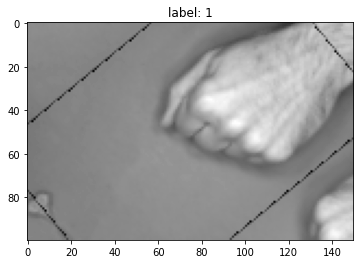

In [ ]:
# example of how to get data for image number 2 in training data and plot with label
image_number = 2
print(images_train_all[image_number,:,:,0])
print(labels_train_all[image_number,:])
plt.imshow(images_train_all[image_number,:,:,0], cmap = 'gray')
plt.title('label: ' + str(int(np.where(labels_train_all[image_number] == 1)[0])))
plt.show()

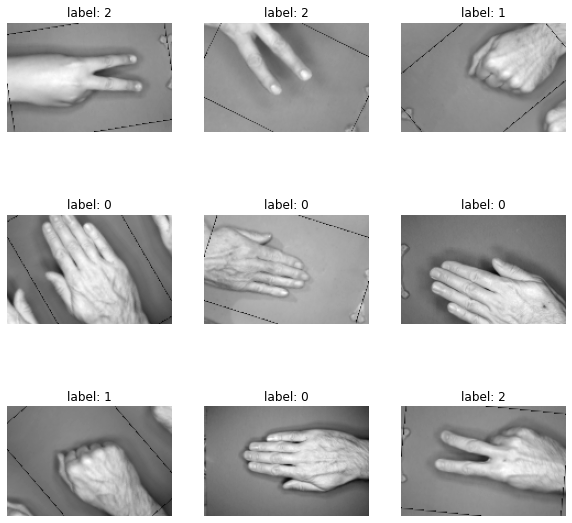

In [ ]:
# plot some of the images with the labels
plt.figure(figsize=(10, 10))
for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images_train_all[i,:,:,0], cmap = 'gray')
      plt.title('label: ' + str(int(np.where(labels_train_all[i] == 1)[0])))
      plt.axis("off")

# Parameter Tuning Experiments

In [ ]:
# update parameters AND file names to reflect parameters
batch_size = 40
epochs = 20 
kernel_size = 5
learning_rate = 0.001
best_model_file = 'aug_best_model_40_5_001_fixed.hdf5'
model_history_file = 'aug_model_history_40_5_001_fixed.csv'
meta_file = 'aug_meta_file_40_5_001_fixed.csv'

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, kernel_size=(kernel_size, kernel_size), 
                 activation='relu',
                 strides = (1,1), 
                 padding = 'SAME',
                 kernel_initializer = TruncatedNormal(stddev = 0.1), 
                 bias_initializer = Constant(value = 0.1)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), 
                       strides = (2,2), 
                       padding = 'SAME'))

In [ ]:
model.add(Conv2D(64, kernel_size=(kernel_size, kernel_size), 
                 activation='relu', 
                 strides = (1,1), 
                 padding = 'SAME',
                 kernel_initializer = TruncatedNormal(stddev = 0.1), 
                 bias_initializer = Constant(value = 0.1)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),
                       strides = (2,2), 
                       padding = 'SAME'))

In [ ]:
model.add(Flatten())

In [ ]:
model.add(Dense(512, activation='relu', 
                kernel_initializer = TruncatedNormal(stddev = 0.1), 
                 bias_initializer = Constant(value = 0.1)))

In [ ]:
# model.add(Dropout(.5)) this made it worse

In [ ]:
model.add(Dense(num_classes, activation='softmax', 
                kernel_initializer = TruncatedNormal(stddev = 0.1), 
                 bias_initializer = Constant(value = 0.1)))

In [ ]:
model.compile(loss= 'categorical_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = learning_rate), 
              metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(best_model_file, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   period=1)
callbacks_list=[model_checkpoint]

In [ ]:
mod = model.fit(images_train_all, labels_train_all,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data = (images_val, labels_val),
          callbacks = callbacks_list)

Epoch 1/20
66/66 - 118s - loss: 736.0405 - accuracy: 0.5080 - val_loss: 5.2520 - val_accuracy: 0.5629
Epoch 2/20
66/66 - 117s - loss: 4.9926 - accuracy: 0.5358 - val_loss: 3.2542 - val_accuracy: 0.6064
Epoch 3/20
66/66 - 119s - loss: 2.4890 - accuracy: 0.6093 - val_loss: 2.5081 - val_accuracy: 0.5858
Epoch 4/20
66/66 - 117s - loss: 2.1500 - accuracy: 0.6173 - val_loss: 2.3178 - val_accuracy: 0.6018
Epoch 5/20
66/66 - 116s - loss: 1.4186 - accuracy: 0.6851 - val_loss: 2.3368 - val_accuracy: 0.6224
Epoch 6/20
66/66 - 122s - loss: 1.1821 - accuracy: 0.7068 - val_loss: 2.4999 - val_accuracy: 0.6430
Epoch 7/20
66/66 - 116s - loss: 0.8383 - accuracy: 0.7662 - val_loss: 2.0446 - val_accuracy: 0.6018
Epoch 8/20
66/66 - 117s - loss: 0.7605 - accuracy: 0.7692 - val_loss: 2.3345 - val_accuracy: 0.6568
Epoch 9/20
66/66 - 116s - loss: 0.5353 - accuracy: 0.8180 - val_loss: 2.6541 - val_accuracy: 0.6201
Epoch 10/20
66/66 - 115s - loss: 0.6068 - accuracy: 0.8085 - val_loss: 2.5917 - val_accuracy: 0.66

In [ ]:
# save model history to csv
df_hist = pd.DataFrame(mod.history)
df_hist.to_csv(model_history_file,index=False)
# get results from best epoch
i = df_hist[['val_loss']].idxmin()[0]
train_loss = df_hist['loss'][i]
train_accuracy = df_hist['accuracy'][i]
val_loss = df_hist['val_loss'][i]
val_accuracy = df_hist['val_accuracy'][i]

In [ ]:
# evaluate on test data
best_model = load_model(best_model_file)
scores = best_model.evaluate(images_test, labels_test, verbose = 0)
test_loss = scores[0]
test_accuracy = scores[1]
print("\ntest %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


test accuracy: 60.27%


In [ ]:
# create confusion matrix
labels_predict_cnn = best_model.predict(images_test)
y_predict_cnn = labels_predict_cnn[:].argmax(axis=1)
y_test = np.where(labels_test[:] == 1)[1]
confusion = confusion_matrix(y_test,y_predict_cnn)
print(confusion)

[[102  26  12]
 [ 88  50   7]
 [ 38   3 112]]


In [ ]:
df_meta = pd.DataFrame(data = {'batch_size':[batch_size],'epochs':[epochs],'kernel_size':[kernel_size],\
                               'learning_rate':[learning_rate],'best_model_file':[best_model_file],\
                               'model_history_file':[model_history_file],'best_epoch':[i+1],'train_loss':[train_loss],\
                               'train_accuracy':[train_accuracy],'val_loss':[val_loss],'val_accuracy':[val_accuracy],\
                               'test_loss':[test_loss],'test_accuracy':[test_accuracy],\
                               'confusion_0_0':[confusion[0,0]],'confusion_0_1':[confusion[0,1]],'confusion_0_2':[confusion[0,2]],\
                               'confusion_1_0':[confusion[1,0]],'confusion_1_1':[confusion[1,1]],'confusion_1_2':[confusion[1,2]],\
                               'confusion_2_0':[confusion[2,0]],'confusion_2_1':[confusion[2,1]],'confusion_2_2':[confusion[2,2]]})
df_meta = df_meta.transpose()
df_meta.to_csv(meta_file)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 150, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 38, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 60800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               31130112  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

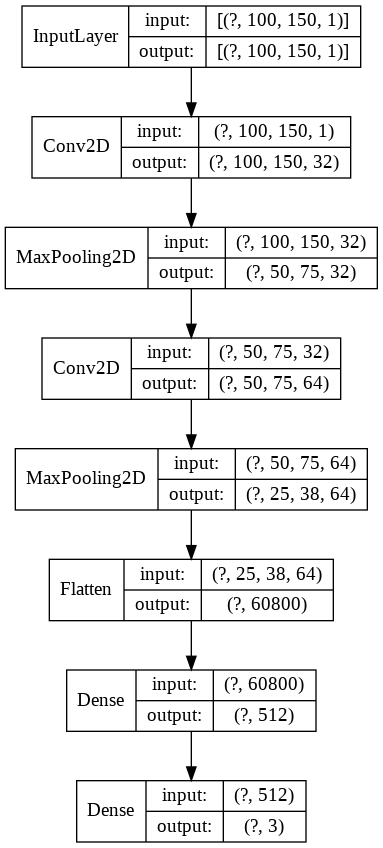

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes = True, show_layer_names = False, to_file = 'cnn.png')

# Inspect bad predictions

In [ ]:
#best_model = load_model('/content/drive/My Drive/Fall_2020_Courses/MA 797/Machine Learning Project/experiment results/actually_augmented/final_model/aug_best_model_40_5_0001_fixed.hdf5')
labels_predict_cnn = best_model.predict(images_test)
y_predict_cnn = labels_predict_cnn[:].argmax(axis=1)
y_test = np.where(labels_test[:] == 1)[1]
mistakes = np.where(y_predict_cnn - y_test != 0)[0]
print(mistakes.shape[0])
mistakes

287


array([  0,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  15,  16,
        17,  18,  19,  20,  21,  24,  26,  29,  30,  33,  35,  37,  39,
        40,  41,  42,  43,  44,  48,  51,  52,  53,  54,  55,  56,  57,
        58,  60,  61,  62,  63,  64,  66,  67,  68,  69,  72,  73,  74,
        75,  78,  79,  80,  81,  84,  87,  89,  91,  92,  94,  97,  98,
        99, 101, 102, 105, 106, 107, 108, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 121, 122, 126, 128, 129, 132, 133, 135, 136, 137,
       142, 144, 146, 147, 149, 150, 153, 154, 158, 159, 160, 161, 162,
       163, 164, 165, 169, 171, 173, 175, 176, 178, 180, 181, 182, 183,
       185, 188, 189, 197, 198, 200, 202, 205, 206, 207, 208, 209, 211,
       212, 213, 214, 215, 216, 218, 221, 223, 224, 226, 229, 230, 231,
       233, 234, 235, 236, 239, 243, 244, 245, 246, 247, 248, 249, 251,
       252, 253, 254, 260, 261, 262, 263, 266, 267, 268, 272, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 285, 286, 287, 28

In [ ]:
scores = best_model.evaluate(images_test, labels_test, verbose = 0)
test_loss = scores[0]
test_accuracy = scores[1]
test_accuracy

0.344748854637146

In [ ]:
import pandas as pd
df_preds = pd.DataFrame(labels_predict_cnn)
df_preds['prediction'] = y_predict_cnn
df_preds['actual'] = y_test
df_preds.loc[mistakes,'mistake'] = 1
df_preds['mistake'] = df_preds['mistake'].fillna(0)
df_preds['max_prob'] = df_preds[[0,1,2]].max(axis=1)
df_preds.to_csv('predictions.csv')

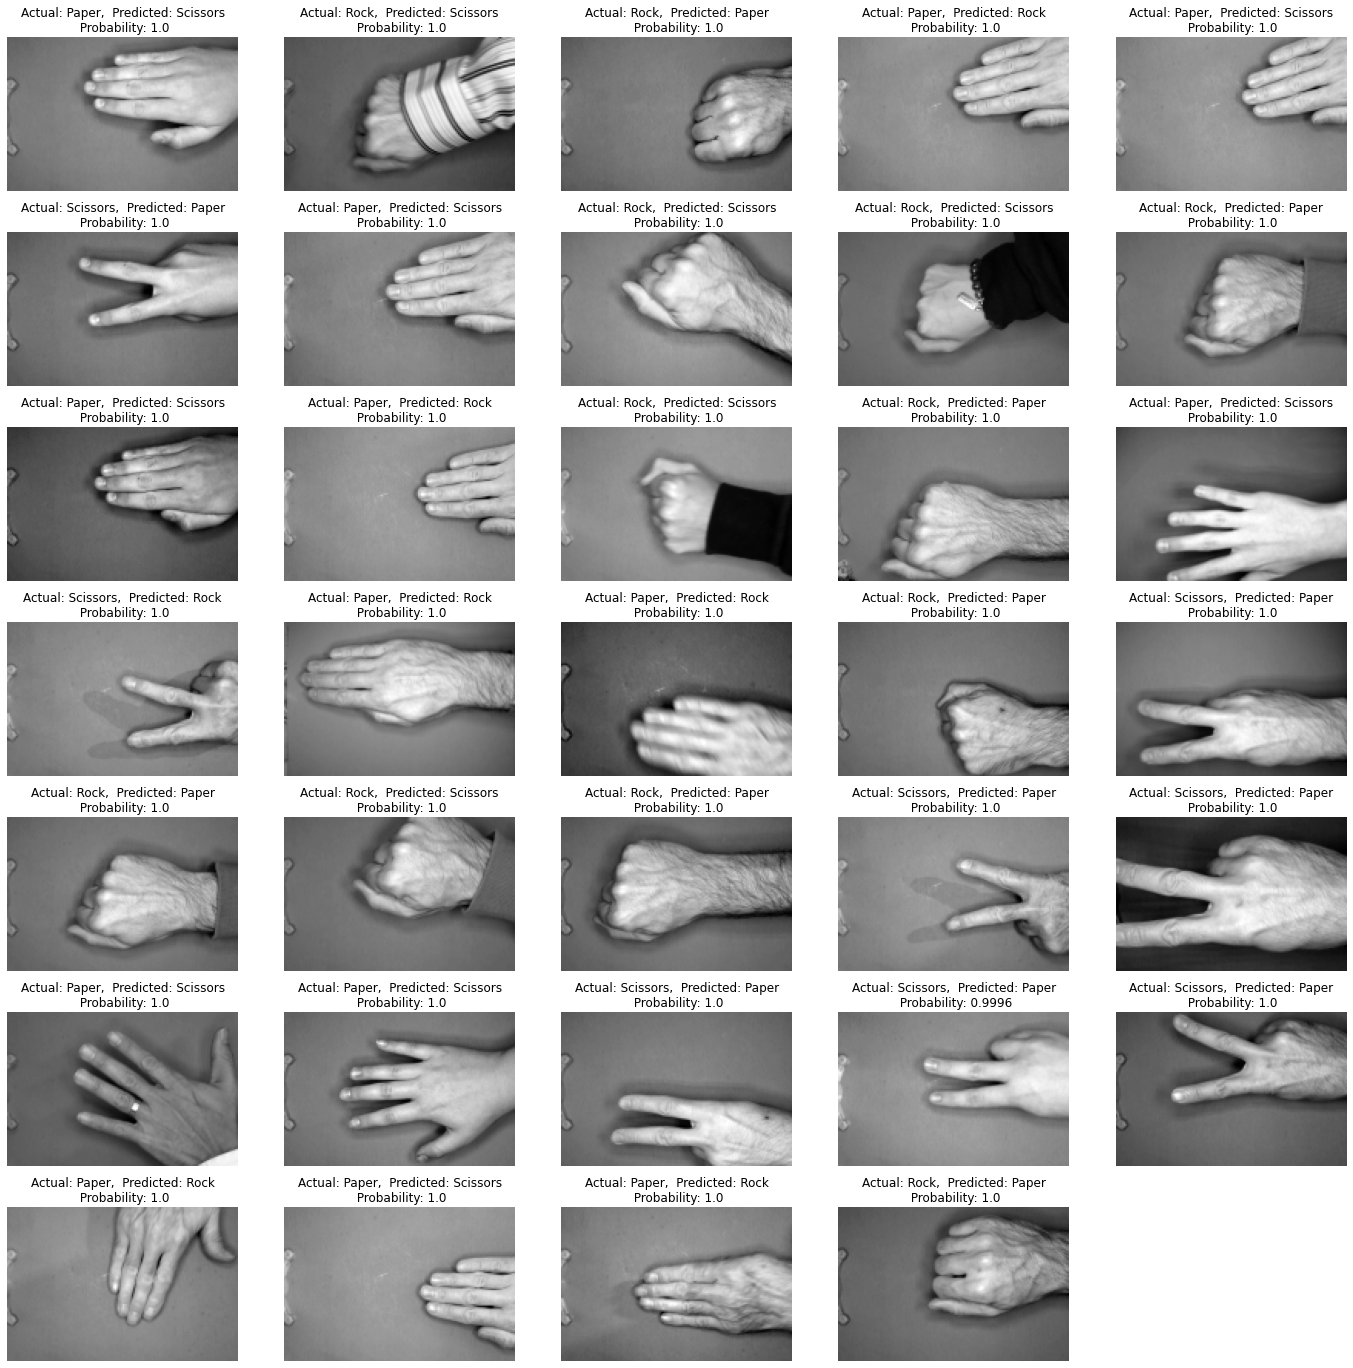

In [ ]:
# plot bad predictions
import math
plt.figure(figsize=(24, math.ceil(mistakes.shape[0]/5)*3.5))
dictionary = {'0':'Paper','1':'Rock','2':'Scissors'}
for i in range(len(mistakes)):
      ax = plt.subplot(math.ceil(mistakes.shape[0]/5), 5, i + 1)
      plt.imshow(images_test[mistakes[i],:,:,0], cmap = 'gray')
      actual_label = dictionary[str(int(y_test[mistakes[i]]))]
      predicted_label = dictionary[str(int(y_predict_cnn[mistakes[i]]))]
      prob = labels_predict_cnn[mistakes[i]].max()
      plt.title('Actual: '  + actual_label + ',  Predicted: ' + predicted_label + '\n Probability: ' + str(round(prob,4)))
      plt.axis("off")

#Get results for final models


In [ ]:
#best_model = load_model('/content/drive/My Drive/Fall_2020_Courses/MA 797/Machine Learning Project/experiment results/actually_augmented/final_model/aug_best_model_40_5_0001_fixed.hdf5')

In [ ]:
# create confusion matrix
labels_predict_cnn = best_model.predict(images_test)
y_predict_cnn = labels_predict_cnn[:].argmax(axis=1)
y_test = np.where(labels_test[:] == 1)[1]
confusion = confusion_matrix(y_test,y_predict_cnn)
print(confusion)
print('Test Accuracy: ' + str(test_accuracy))

[[126   6   8]
 [  7 133   5]
 [  7   1 145]]
Test Accuracy: 0.922374427318573


In [ ]:
import sklearn
from sklearn.metrics import classification_report
class_report = sklearn.metrics.classification_report(y_test,y_predict_cnn)
print(class_report)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       140
           1       0.95      0.92      0.93       145
           2       0.92      0.95      0.93       153

    accuracy                           0.92       438
   macro avg       0.92      0.92      0.92       438
weighted avg       0.92      0.92      0.92       438



# plot loss and accuracy over epochs

In [ ]:
#df_hist = pd.read_csv('/content/drive/My Drive/Fall_2020_Courses/MA 797/Machine Learning Project/experiment results/actually_augmented/final_model/aug_model_history_40_5_0001_fixed.csv')
df_hist

,loss,accuracy,val_loss,val_accuracy
0,155.185425,0.416984,41.500141,0.627002
1,42.220432,0.570449,28.061666,0.665904
2,27.967016,0.674029,19.328621,0.800915
3,28.737904,0.700305,34.825909,0.681922
4,22.416039,0.729246,13.025886,0.803204
5,9.618302,0.832064,7.496914,0.899314
6,6.852324,0.863290,14.670330,0.821510
7,10.554767,0.814547,8.350538,0.901602
8,4.184749,0.899467,7.398252,0.892448
9,3.860962,0.905179,7.437543,0.867277


In [ ]:
best_epoch = df_hist[['val_loss']].idxmin()[0]+1 #actual number not python index
best_epoch

18

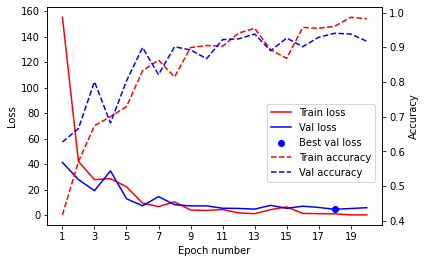

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Loss')
ax1.plot(np.arange(1,21), df_hist['loss'], '-r', label = 'Train loss')
ax1.plot(np.arange(1,21), df_hist['val_loss'], '-b', label = 'Val loss')
plt.scatter(best_epoch,df_hist['val_loss'][best_epoch],c='b',label='Best val loss')
ax1.tick_params(axis='y')
#plt.legend(loc='lower right')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(np.arange(1,21), df_hist['accuracy'], '--r', label = 'Train accuracy')
ax2.plot(np.arange(1,21), df_hist['val_accuracy'], '--b', label = 'Val accuracy')
ax2.tick_params(axis='y')
plt.xticks(np.arange(1, 21, 2))
#plt.legend(loc='right')
fig.legend(loc = 'upper right', bbox_to_anchor=(.88,.57))
plt.savefig('acc_val_plot.png')
plt.show()


# Baseline methods



In [ ]:
#Vanilla Neural Network
from sklearn import svm, metrics
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.initializers import Constant, TruncatedNormal

#get image shape and flatted to a 1d tensor, then fit linear regression/vanilla NN or SVM
epochs = 5
batch_size = 10 #images_train.shape[0]
VNN = Sequential()
VNN.add(Flatten()) #flatten inputs
VNN.add(Dense(1000, activation = 'relu')) #linear regression Vanilla NN
VNN.add(Dense(num_classes, activation = 'softmax')) #output layer
VNN.compile(loss= 'categorical_crossentropy',
              optimizer = 'adam', 
              metrics=['accuracy']) #keras.optimizers.Adam(learning_rate = 1e-4)
#historyVNN = VNN.fit(images_train, labels_train,
historyVNN = VNN.fit(images_train_all, labels_train_all,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data = (images_val, labels_val))
scoresVNN = VNN.evaluate(images_test, labels_test, verbose = 0)
print("Test accuracy: {:.4f}".format(scoresVNN[1]))
from keras.utils import plot_model

Epoch 1/5
263/263 [==============================] - 21s 79ms/step - loss: 637.1762 - accuracy: 0.3686 - val_loss: 68.2930 - val_accuracy: 0.5881
Epoch 2/5
263/263 [==============================] - 20s 78ms/step - loss: 234.8563 - accuracy: 0.4242 - val_loss: 97.7978 - val_accuracy: 0.4760
Epoch 3/5
263/263 [==============================] - 20s 78ms/step - loss: 101.1865 - accuracy: 0.4337 - val_loss: 53.5340 - val_accuracy: 0.3890
Epoch 4/5
263/263 [==============================] - 21s 79ms/step - loss: 41.8671 - accuracy: 0.4570 - val_loss: 32.1496 - val_accuracy: 0.4233
Epoch 5/5
263/263 [==============================] - 20s 78ms/step - loss: 21.5441 - accuracy: 0.4547 - val_loss: 7.4538 - val_accuracy: 0.4783
Test accuracy: 0.4817


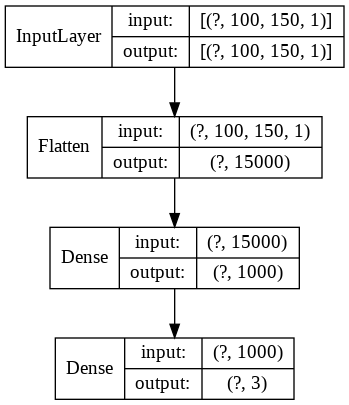

In [ ]:
plot_model(VNN, show_shapes = True, show_layer_names = False)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_predict = VNN.predict(images_test)
y_pred = y_predict[:].argmax(axis=1)
y_true = labels_test[:].argmax(axis=1)
cf = confusion_matrix(y_true = y_true, y_pred=y_pred)
acc = accuracy_score(y_true = y_true, y_pred = y_pred)
print(cf)
print('Accuracy score: ', acc)
class_report = classification_report(y_true,y_pred)
print(class_report)

[[ 24  35  81]
 [  5  48  92]
 [  3  11 139]]
Accuracy score:  0.4817351598173516
              precision    recall  f1-score   support

           0       0.75      0.17      0.28       140
           1       0.51      0.33      0.40       145
           2       0.45      0.91      0.60       153

    accuracy                           0.48       438
   macro avg       0.57      0.47      0.43       438
weighted avg       0.56      0.48      0.43       438



In [ ]:
VNN.save('vnn_model.hdf5')

In [ ]:
#SVM
#create classifier
from sklearn import svm, metrics
classifier = svm.SVC()
#print(images_train.shape)
#print(labels_train.shape)
print(images_train_all.shape)
print(labels_train_all.shape)
#flattened_train = np.empty(shape=(images_train.shape[0], 15000))
flattened_train = np.empty(shape=(images_train_all.shape[0], 15000)) 
flattened_test = np.empty(shape=(images_test.shape[0],15000))

count = 0
#for (im_train, im_test) in zip(images_train,images_test):
for (im_train, im_test) in zip(images_train_all,images_test):
  flattened_train[count,:] = im_train.reshape(1,15000)
  flattened_test[count,:] = im_test.reshape(1,15000)
  count += 1
#row, labels_train_1 = np.where(labels_train[:] == 1)
row, labels_train_1 = np.where(labels_train_all[:] == 1)

row, labels_test_1 = np.where(labels_test[:] == 1)
print(labels_train_1.shape)
#print(labels_train.sum())
print(labels_train_all.sum())

classifier.fit(flattened_train, labels_train_1)


(2626, 100, 150, 1)
(2626, 3)
(2626,)
2626.0


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = classifier.predict(flattened_test)
cf = confusion_matrix(y_true = labels_test_1, y_pred = y_pred)
acc = accuracy_score(y_true = labels_test_1, y_pred = y_pred)
print(cf)
print('Accuracy score: ', acc)
class_report = classification_report(y_true = labels_test_1, y_pred =y_pred)
print(class_report)

[[  0   0 140]
 [  0   0 145]
 [  0   0 153]]
Accuracy score:  0.3493150684931507
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.00      0.00      0.00       145
           2       0.35      1.00      0.52       153

    accuracy                           0.35       438
   macro avg       0.12      0.33      0.17       438
weighted avg       0.12      0.35      0.18       438



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
